<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/6_2_Predictions_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Make predictions using the LSTM model**

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Import Google Drive
from google.colab import drive

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Access Google Drive, as we will read files from the cloud
drive.mount('/content/drive')

# Define the path with the time series SPQ data
traffic_data = '/content/drive/MyDrive/Paper/Timeseries/traffic_flow_SPQ.csv'

# Read dataset
time_series = pd.read_csv(traffic_data)

Mounted at /content/drive


Preprocess traffic flow data

In [3]:
# This list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# Generate the columns of the dataset
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))

    if (columns[i]>=pd.to_datetime('2008-06-10 09:30:04')):
        break

    i+=1

# Delete the last timestamp
columns.pop()

# Assign new column names to our dataframe
time_series.columns = columns

# Generate new time columns for the dataseT
dates = []
i = 0
while(True):
    if i == 0:
        dates.append(columns[-1] + timedelta(seconds=1800))
    else:
        dates.append(dates[i-1] + timedelta(seconds=1800))

    if (dates[i] == pd.to_datetime('2008-06-10 11:30:04')):
        break

    i+=1

# Add new columns to dataset
for value in dates:
    column_name = str(value)
    time_series[column_name] = -1

id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = time_series.iloc[:,2:].columns

# Reshape the data from wide format to long format using pandas melt function
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')

# Change time column to datetime format
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# Sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

# Convert path column from categorical to numerical using Label Encoder library
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# Sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

# Define new index for traffic flow data
time_series.set_index('Time Column', inplace=True)

# Create a copy of time series dataset
roudolf = time_series.copy()

# Change the index of time series
time_series = time_series.reset_index()
time_series.rename(columns={'index': 'Time Column'}, inplace=True)

In [4]:
# Plot first rows of dataframe
time_series.head(5)

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow
0,2008-05-17 10:00:04,108,5,0,20,0
1,2008-05-17 10:30:04,108,5,0,20,0
2,2008-05-17 11:00:04,108,5,0,20,0
3,2008-05-17 11:30:04,108,5,0,20,1
4,2008-05-17 12:00:04,108,5,0,20,0


Add extra time-related features

In [5]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Extract Time Components
time_series['hour'] = time_series['Time Column'].dt.hour
time_series['dayofweek'] =time_series['Time Column'].dt.dayofweek
time_series['day'] = time_series['Time Column'].dt.day
time_series['minute'] = time_series['Time Column'].dt.minute

### Circular Encoding for Cyclic Time Features ###

# Encode hour as sine and cosine values to handle cyclic nature
time_series['hour_sin'] = np.sin(2 * np.pi * time_series['hour'] / 24)
time_series['hour_cos'] = np.cos(2 * np.pi * time_series['hour'] / 24)

# Encode day of the week as sine and cosine values to handle cyclic nature
time_series['day_of_week_sin'] = np.sin(2 * np.pi * time_series['dayofweek'] / 7)
time_series['day_of_week_cos'] = np.cos(2 * np.pi * time_series['dayofweek'] / 7)

# Encode day of the month as sine and cosine values to handle cyclic nature
time_series['day_sin'] = np.sin(2 * np.pi * time_series['day'] / 31)
time_series['day_cos'] = np.cos(2 * np.pi * time_series['day'] / 31)

# Encode minute as sine and cosine values to handle cyclic nature
time_series['minute_sin'] = np.sin(2 * np.pi * time_series['minute'] / 60)
time_series['minute_cos'] = np.cos(2 * np.pi * time_series['minute'] / 60)

# Apply the custom function on the data to create the '3hour_interval' column
time_series['3hour_interval'] = time_series['hour'].apply(get_3hour_interval)  # Make sure get_3hour_interval is defined

Use the sliding window tecnique on the data

In [6]:
# Define sliding window method

from pandas import DataFrame
from pandas import concat

# Create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data,n_in=1,n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the culumns.
    """
    new_data = pd.DataFrame()
    for item in data['Path'].unique():

        # Call function only for traffic flow columns
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # The rest of the columns are concatenated as they were
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, time_series[time_series['Path'] == item]], axis=1)

        new_data = pd.concat([new_data,supervised_traffic_flow])

    new_data.dropna(inplace=True)
    return new_data

time_series = generate_X_y_pairs(time_series,6)

# Reset index of dataframe
time_series.reset_index(drop=True,inplace=True)

In [7]:
# Print dataset
time_series.head()

,Traffic Flow 1(t-6),Traffic Flow 1(t-5),Traffic Flow 1(t-4),Traffic Flow 1(t-3),Traffic Flow 1(t-2),Traffic Flow 1(t-1),Traffic Flow 1(t),Time Column,Taxi ID,Traj ID,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,0.0,0.0,0.0,1.0,0.0,0.0,1,2008-05-17 13:00:04,108,5,...,0,-0.258819,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5
1,0.0,0.0,1.0,0.0,0.0,1.0,0,2008-05-17 13:30:04,108,5,...,30,-0.258819,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,5
2,0.0,1.0,0.0,0.0,1.0,0.0,0,2008-05-17 14:00:04,108,5,...,0,-0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5
3,1.0,0.0,0.0,1.0,0.0,0.0,2,2008-05-17 14:30:04,108,5,...,30,-0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,5
4,0.0,0.0,1.0,0.0,0.0,2.0,0,2008-05-17 15:00:04,108,5,...,0,-0.707107,-0.707107,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,6


Make forecasts of traffic flow using the XGBoost model

In [8]:
from keras.models import load_model

# Specify the path to your H5 model file
model_path = '/content/drive/MyDrive/Paper/Models/LSTM-length-6.h5'

# Load the model from the H5 file
loaded_model = load_model(model_path)

In [9]:
# Import Min Max Scaler
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

In [11]:
# List with all the fututre timestamps
# Traffic flow at these unknown timestamps needs to be estimated
news = time_series[time_series['Time Column'] >= pd.to_datetime('2008-06-10 09:00:04')]['Time Column'].to_list()

In [12]:
# Loop over unique paths in the time series data
for path in time_series['Path'].unique():
    print('Data of path', path)

    # Loop over the future timestamps
    for time in news:
        # Select data for the specific path and time
        select = time_series[(time_series['Time Column'] == time) & (time_series.Path == path)]

        # Calculate rolling mean and rolling variance
        select['rolling_mean'] = select.iloc[:, 0:6].mean(axis=1)
        select['rolling_var'] = select.iloc[:, 0:6].var(axis=1)

        # Select only necessary features
        fit = select[['Traffic Flow 1(t-6)','Traffic Flow 1(t-5)', 'Traffic Flow 1(t-4)', 'Traffic Flow 1(t-3)', 'Traffic Flow 1(t-2)',
           'Traffic Flow 1(t-1)', 'Taxi ID', 'Traj ID', 'Path',
           'Length', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
           'day_sin', 'day_cos', 'minute_sin', 'minute_cos', '3hour_interval',
           'rolling_mean', 'rolling_var']]


        fit = scaler.fit_transform(fit)
        fit = fit.reshape(-1,1,21)
        # Make predictions using the loaded XGBoost model
        x = loaded_model.predict(fit,verbose=0)

        # Convert predicted values to integers and update the 'Traffic Flow' column in 'roudolf'
        float_list = [int(round(float(value_str))) for value_str in x]
        roudolf.loc[(roudolf['Path'] == path) & (roudolf.index == time), 'Traffic Flow'] = float_list

        # Change the future values in 'time_series' dataframe. Forecasted value is now the current value,
        # while the others are sliding one position, on the left
        time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-6)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t-5)'].iloc[0]
        time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-5)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t-4)'].iloc[0]
        time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-4)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t-3)'].iloc[0]
        time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-3)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t-2)'].iloc[0]
        time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-2)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t-1)'].iloc[0]
        time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-1)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t)'].iloc[0]
        time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time),'Traffic Flow 1(t)'] = float_list

Data of path 0
Data of path 1
Data of path 2
Data of path 3
Data of path 4
Data of path 5
Data of path 6
Data of path 7
Data of path 8
Data of path 9
Data of path 10
Data of path 11
Data of path 12
Data of path 13
Data of path 14
Data of path 15
Data of path 16
Data of path 17
Data of path 18
Data of path 19
Data of path 20
Data of path 21
Data of path 22
Data of path 23
Data of path 24
Data of path 25
Data of path 26
Data of path 27
Data of path 28
Data of path 29
Data of path 30
Data of path 31
Data of path 32
Data of path 33
Data of path 34
Data of path 35
Data of path 36
Data of path 37
Data of path 38
Data of path 39
Data of path 40
Data of path 41
Data of path 42
Data of path 43
Data of path 44
Data of path 45
Data of path 46
Data of path 47
Data of path 48
Data of path 49
Data of path 50
Data of path 51
Data of path 52
Data of path 53
Data of path 54
Data of path 55
Data of path 56
Data of path 57
Data of path 58
Data of path 59
Data of path 60
Data of path 61
Data of path 62
Da

In [15]:
# Reset Index
roudolf = roudolf.reset_index()

# Select only values pf 2 most recent days
subset = roudolf[roudolf['Time Column']>='2008-06-09']

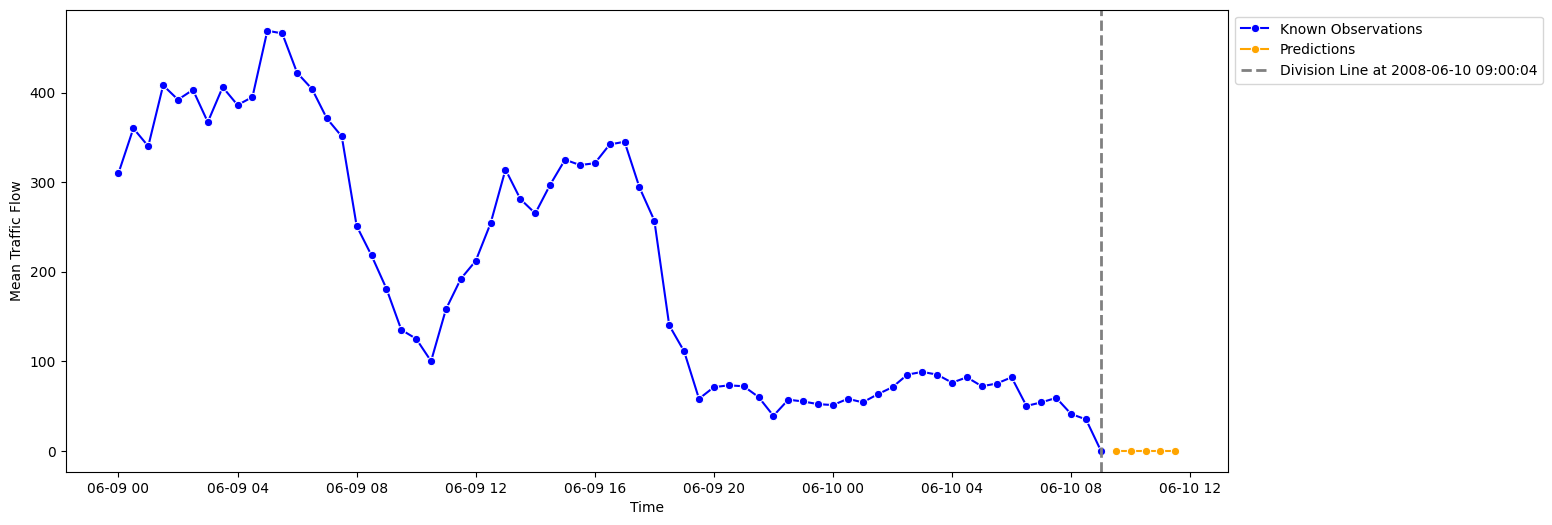

In [16]:
# Print the average traffic flow on all paths grouped by timestamp
avg_grouped_df_SPQ = subset['Traffic Flow'].groupby(subset['Time Column']).sum()
avg_grouped_df_SPQ = pd.DataFrame(avg_grouped_df_SPQ, index=avg_grouped_df_SPQ.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting known observations (before the division line)
sns.lineplot(x=avg_grouped_df_SPQ.index[avg_grouped_df_SPQ.index <= pd.to_datetime('2008-06-10 09:00:04')],
             y='Traffic Flow', data=avg_grouped_df_SPQ[avg_grouped_df_SPQ.index <= pd.to_datetime('2008-06-10 09:00:04')],
             color='blue', marker='o', alpha=1, label='Known Observations')

# Plotting predictions (after the division line)
sns.lineplot(x=avg_grouped_df_SPQ.index[avg_grouped_df_SPQ.index > pd.to_datetime('2008-06-10 09:00:04')],
             y='Traffic Flow', data=avg_grouped_df_SPQ[avg_grouped_df_SPQ.index > pd.to_datetime('2008-06-10 09:00:04')],
             color='orange', marker='o', alpha=1, label='Predictions')

# Adding a vertical line
plt.axvline(x=pd.to_datetime('2008-06-10 09:00:04'), color='grey', linestyle='--', linewidth=2, label='Division Line at 2008-06-10 09:00:04')

plt.xlabel('Time')
plt.ylabel('Mean Traffic Flow')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Display the plot
plt.show()